# A Gentle Introduction to Transfer Learning

In [1]:
import sys
import os
import numpy as np
from collections import Counter
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import lr_scheduler, SGD
from torch.autograd import Variable
from torchvision import models
from utils import (get_gpu_name, get_number_processors, plot_pytorch_data_stream, train_model, create_dataset, 
                   available_models, plot_metrics)

print("OS: ", sys.platform)
print("Python: ", sys.version)
print("PyTorch: ", torch.__version__)
print("Numpy: ", np.__version__)
print("Number of CPU processors: ", get_number_processors())
print("GPU: ", get_gpu_name())

%matplotlib inline
%load_ext autoreload
%autoreload 2

OS:  linux
Python:  3.5.2 |Anaconda custom (64-bit)| (default, Jul  2 2016, 17:53:06) 
[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]
PyTorch:  0.2.0_3
Numpy:  1.13.3
Number of CPU processors:  24
GPU:  ['Tesla M60', 'Tesla M60', 'Tesla M60', 'Tesla M60']


In [2]:
torch.backends.cudnn.benchmark=True # enables cudnn's auto-tuner

In [3]:
MODEL_NAME = 'resnet18'
BATCH_SIZE = 64
SETS = ['train', 'val']
EPOCHS = 25
LR = 0.001
LR_STEP = 0.1
LR_EPOCHS = 7
MOMENTUM = 0.9

## Model and utilities

In [4]:
model_names = available_models()
print(model_names)

['alexnet', 'densenet121', 'densenet161', 'densenet169', 'densenet201', 'inception_v3', 'resnet101', 'resnet152', 'resnet18', 'resnet34', 'resnet50', 'squeezenet1_0', 'squeezenet1_1', 'vgg11', 'vgg11_bn', 'vgg13', 'vgg13_bn', 'vgg16', 'vgg16_bn', 'vgg19', 'vgg19_bn']


In [5]:
def finetune(dataloaders, model_name, num_epochs, lr, momentum, lr_step, lr_epochs):
    num_class = len(dataloaders['train'].dataset.class_to_idx)
    model_ft = models.__dict__[model_name](pretrained=True)
    num_ftrs = model_ft.fc.in_features
    model_ft.fc = nn.Linear(num_ftrs, num_class)
    model_ft = model_ft.cuda()
    #loss
    criterion = nn.CrossEntropyLoss()

    # Observe that all parameters are being optimized
    optimizer = SGD(model_ft.parameters(), lr=lr, momentum=momentum)

    # Decay LR by a factor of lr_step every lr_epochs epochs
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=lr_epochs, gamma=lr_step)
    model_ft = train_model(dataloaders, model_ft, criterion, optimizer, exp_lr_scheduler, num_epochs=num_epochs)
    return model_ft

In [6]:
def freeze_and_train(dataloaders, model_name, num_epochs, lr, momentum, lr_step, lr_epochs):
    num_class = len(dataloaders['train'].dataset.class_to_idx)
    model_conv = models.__dict__[model_name](pretrained=True)
    for param in model_conv.parameters():
        param.requires_grad = False

    # Parameters of newly constructed modules have requires_grad=True by default
    num_ftrs = model_conv.fc.in_features
    model_conv.fc = nn.Linear(num_ftrs, num_class)
    model_conv = model_conv.cuda()
    #loss
    criterion = nn.CrossEntropyLoss()

    # Observe that only parameters of final layer are being optimized 
    optimizer = SGD(model_conv.fc.parameters(), lr=lr, momentum=momentum)

    # Decay LR by a factor of lr_step every lr_epochs epochs
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=lr_epochs, gamma=lr_step)
    model_conv = train_model(dataloaders, model_conv, criterion, optimizer, exp_lr_scheduler, num_epochs=num_epochs)
    return model_conv

## Datasets
We are going to use the dataset [hymenoptera](https://download.pytorch.org/tutorial/hymenoptera_data.zip)

In [7]:
DATA_ROOT = 'data'
HYMENOPTERA_ROOT = os.path.join(DATA_ROOT, 'hymenoptera_data')

In [8]:
data_hymenoptera = create_dataset(HYMENOPTERA_ROOT)

There are 2 clases in the dataset: {'bees': 1, 'ants': 0}
Sets sizes:  {'val': 153, 'train': 244}
Number of items in set train: {0: 123, 1: 121}
Number of items in set val: {0: 70, 1: 83}


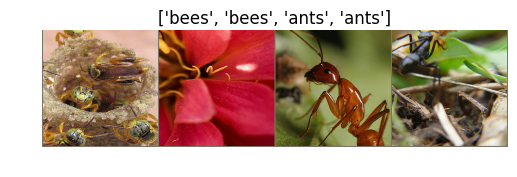

In [9]:
plot_pytorch_data_stream(data_hymenoptera['train'], max_images=4)

In [10]:
model, metrics = finetune(data_hymenoptera, MODEL_NAME, EPOCHS, LR, MOMENTUM, LR_STEP, LR_EPOCHS)


Epoch 1/25
----------
val Loss: 0.0180 Acc: 0.7451
train Loss: 0.0210 Acc: 0.6025

Epoch 2/25
----------
val Loss: 0.0128 Acc: 0.8627
train Loss: 0.0134 Acc: 0.8484

Epoch 3/25
----------
val Loss: 0.0085 Acc: 0.9346
train Loss: 0.0098 Acc: 0.8893

Epoch 4/25
----------
val Loss: 0.0064 Acc: 0.9346
train Loss: 0.0080 Acc: 0.9016

Epoch 5/25
----------
val Loss: 0.0062 Acc: 0.9477
train Loss: 0.0067 Acc: 0.9139

Epoch 6/25
----------
val Loss: 0.0056 Acc: 0.9542
train Loss: 0.0051 Acc: 0.9426

Epoch 7/25
----------
val Loss: 0.0052 Acc: 0.9477
train Loss: 0.0051 Acc: 0.9590

Epoch 8/25
----------
val Loss: 0.0055 Acc: 0.9412
train Loss: 0.0048 Acc: 0.9549

Epoch 9/25
----------
val Loss: 0.0054 Acc: 0.9412
train Loss: 0.0049 Acc: 0.9549

Epoch 10/25
----------
val Loss: 0.0055 Acc: 0.9412
train Loss: 0.0047 Acc: 0.9508

Epoch 11/25
----------
val Loss: 0.0053 Acc: 0.9477
train Loss: 0.0036 Acc: 0.9836

Epoch 12/25
----------
val Loss: 0.0054 Acc: 0.9477
train Loss: 0.0041 Acc: 0.9672



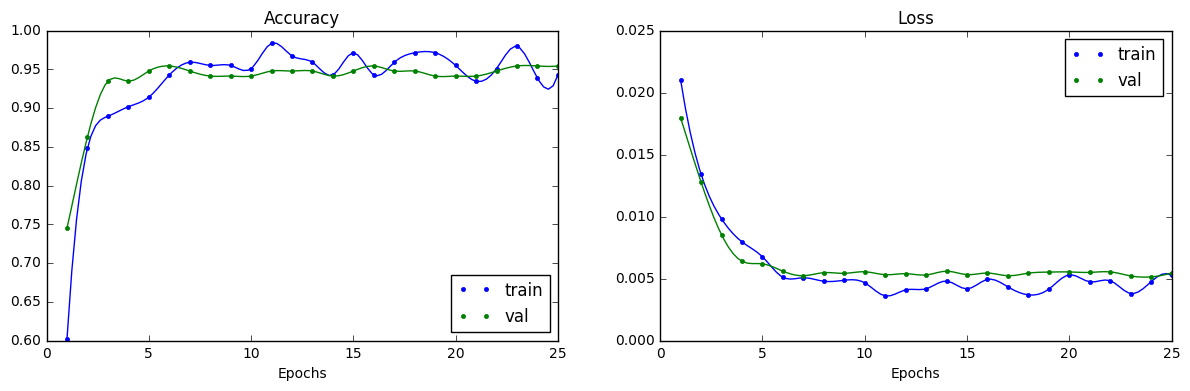

In [11]:
plot_metrics(metrics)

In [12]:
model, metrics = freeze_and_train(data_hymenoptera, MODEL_NAME, EPOCHS, LR, MOMENTUM, LR_STEP, LR_EPOCHS)


Epoch 1/25
----------
val Loss: 0.0263 Acc: 0.4314
train Loss: 0.0242 Acc: 0.5082

Epoch 2/25
----------
val Loss: 0.0198 Acc: 0.7059
train Loss: 0.0186 Acc: 0.7295

Epoch 3/25
----------
val Loss: 0.0148 Acc: 0.8301
train Loss: 0.0135 Acc: 0.8238

Epoch 4/25
----------
val Loss: 0.0102 Acc: 0.9412
train Loss: 0.0123 Acc: 0.8238

Epoch 5/25
----------
val Loss: 0.0084 Acc: 0.9412
train Loss: 0.0095 Acc: 0.9098

Epoch 6/25
----------
val Loss: 0.0076 Acc: 0.9477
train Loss: 0.0094 Acc: 0.8893

Epoch 7/25
----------
val Loss: 0.0069 Acc: 0.9412
train Loss: 0.0071 Acc: 0.9344

Epoch 8/25
----------
val Loss: 0.0066 Acc: 0.9542
train Loss: 0.0080 Acc: 0.9180

Epoch 9/25
----------
val Loss: 0.0066 Acc: 0.9542
train Loss: 0.0084 Acc: 0.9180

Epoch 10/25
----------
val Loss: 0.0069 Acc: 0.9542
train Loss: 0.0075 Acc: 0.9262

Epoch 11/25
----------
val Loss: 0.0066 Acc: 0.9542
train Loss: 0.0084 Acc: 0.8975

Epoch 12/25
----------
val Loss: 0.0064 Acc: 0.9542
train Loss: 0.0071 Acc: 0.9508



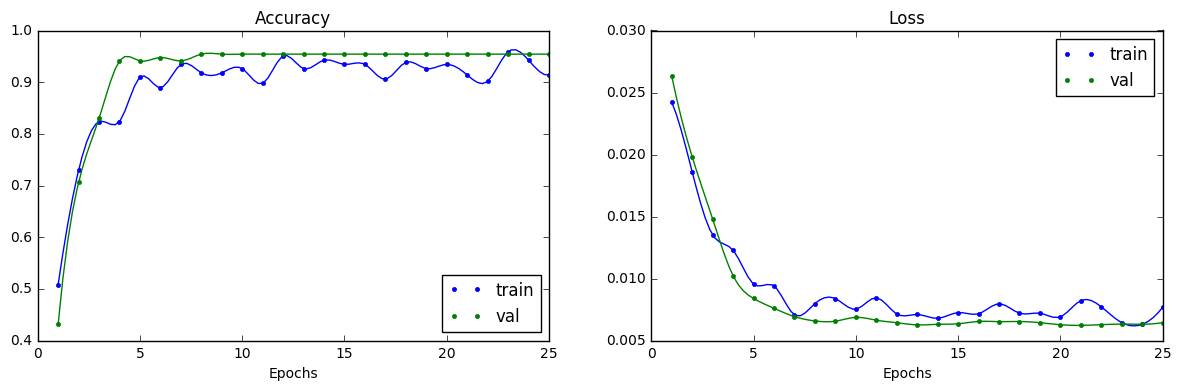

In [13]:
plot_metrics(metrics)